# Segment Blood Vessels

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
from numpy.typing import NDArray
from typing import List, Tuple

In [3]:
def print_info(name : str, var : NDArray ) -> None:
    print(f"{name}.shape={var.shape} {name}.dtype={var.dtype}")

In [4]:
def show_image(img : NDArray, title : str, dpi : int = 90) -> None:
    plt.figure(figsize=(16,9), dpi=dpi)
    _ = plt.imshow(img)
    _ = plt.title(title) 

In [5]:
img = cv2.imread('input/input.png')
print_info('img',img)

img.shape=(400, 322, 3) img.dtype=uint8


In [6]:
regions_img = cv2.cvtColor(
    cv2.imread('input/regions.png'),
    cv2.COLOR_RGB2BGR
)
print_info('regions_img',regions_img)

regions_img.shape=(400, 322, 3) regions_img.dtype=uint8


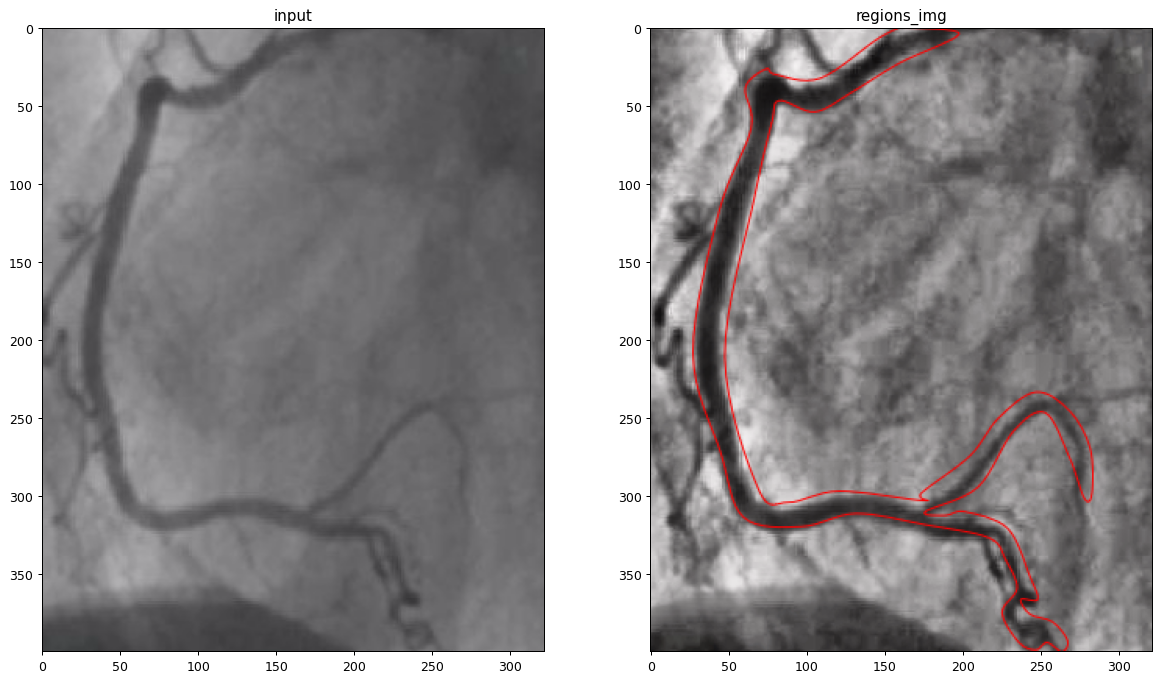

In [7]:
plt.figure(figsize=(16,9), dpi=90)
plt.subplot(1,2,1)
plt.imshow(img)
plt.gca().set_title('input')
plt.subplot(1,2,2)
plt.imshow(regions_img)
plt.gca().set_title('regions_img')
plt.show()

In [8]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = cv2.cvtColor( 
                clahe.apply( 
                    cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
                ), 
                cv2.COLOR_GRAY2RGB
            )
print_info('equalized', equalized)
#print(f"equalized.shape={equalized.shape}")

equalized.shape=(400, 322, 3) equalized.dtype=uint8


In [9]:
def histogram_plot(img : NDArray, title : str = None, dpi : int = 90):
    hist, bins = np.histogram( img.ravel(), bins=256, range=[0,256])
    plt.figure(figsize=(16,9), dpi=dpi)
    plt.plot(bins[:-1], hist / hist.sum())
    if title:
        plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    return bins[:-1], hist

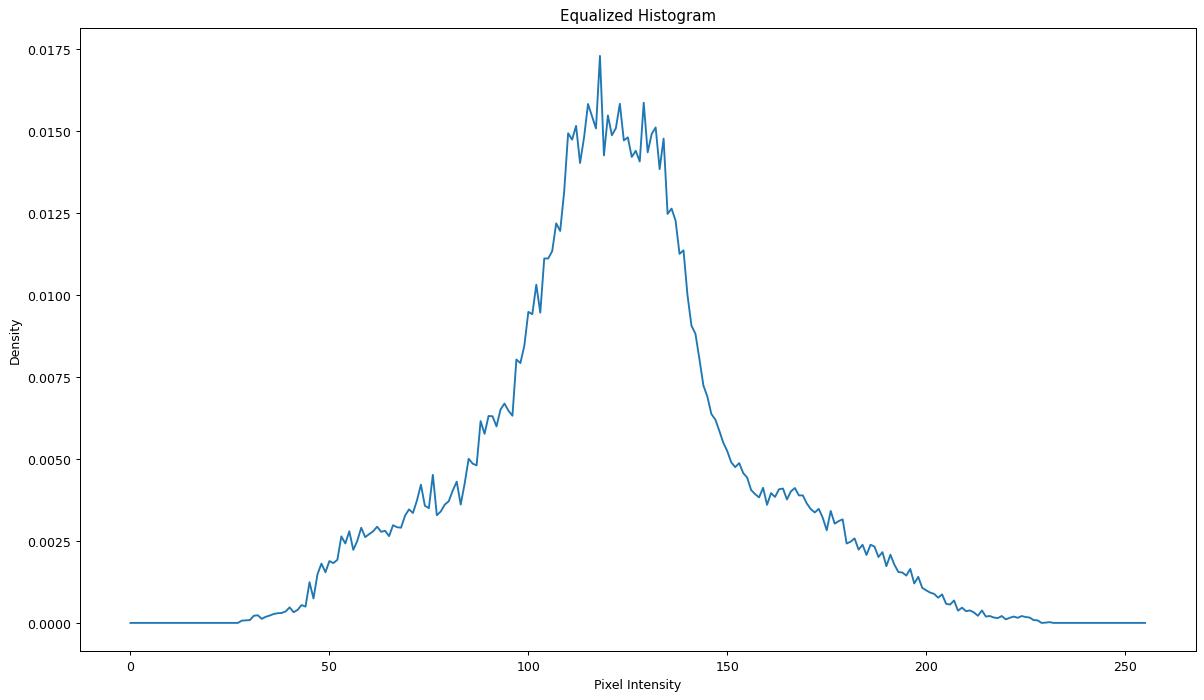

In [10]:
_ = histogram_plot(equalized[:,:,0], "Equalized Histogram")

In [11]:
def show_channels(img : NDArray, suptitle : str = None, subtitles : list = None, dpi : int = 90):
    fig = plt.figure(figsize=(16,9), dpi=dpi)
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        if subtitles:
            plt.gca().set_title(subtitles[i])
        plt.imshow(img[:,:,i], 'gray')
    if suptitle is not None:
        fig.suptitle(suptitle, size=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

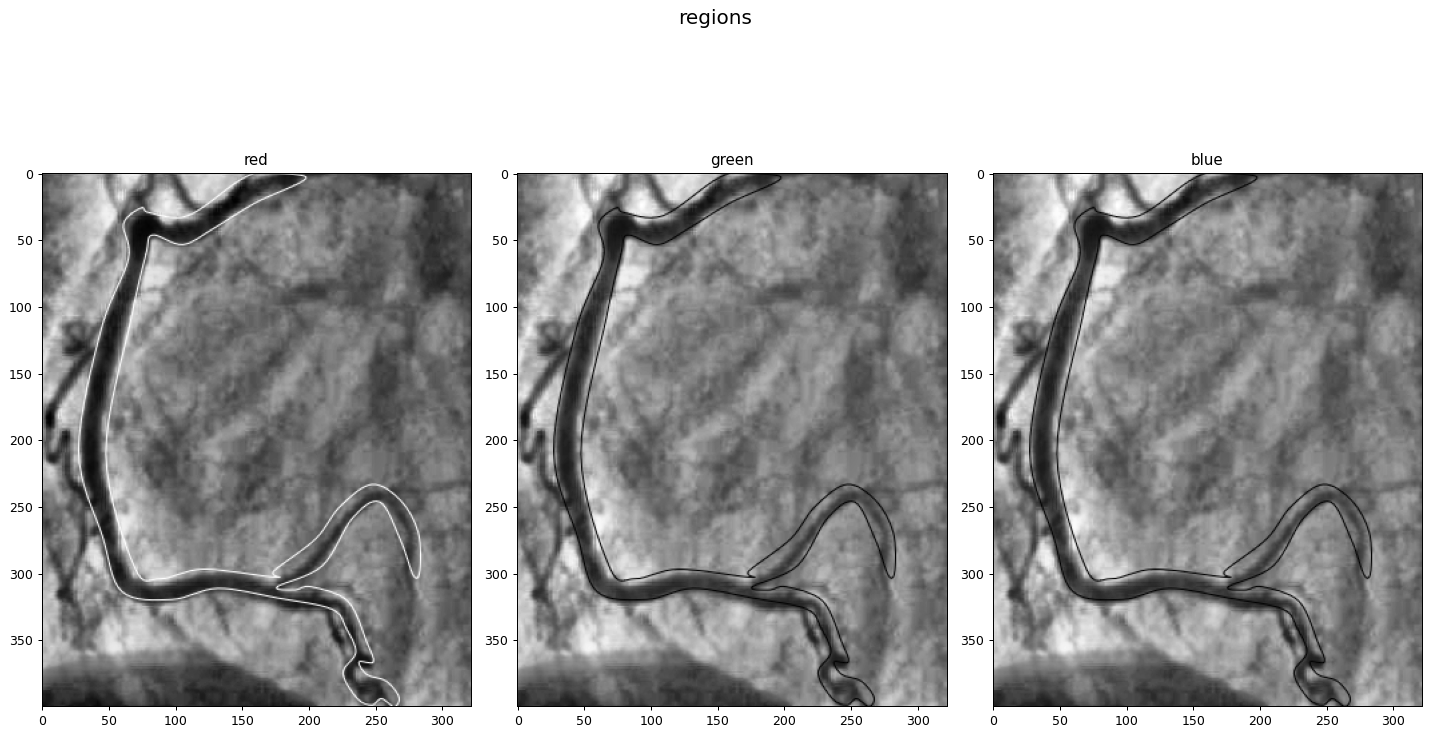

In [12]:
show_channels(regions_img, suptitle="regions", subtitles=['red','green','blue'])

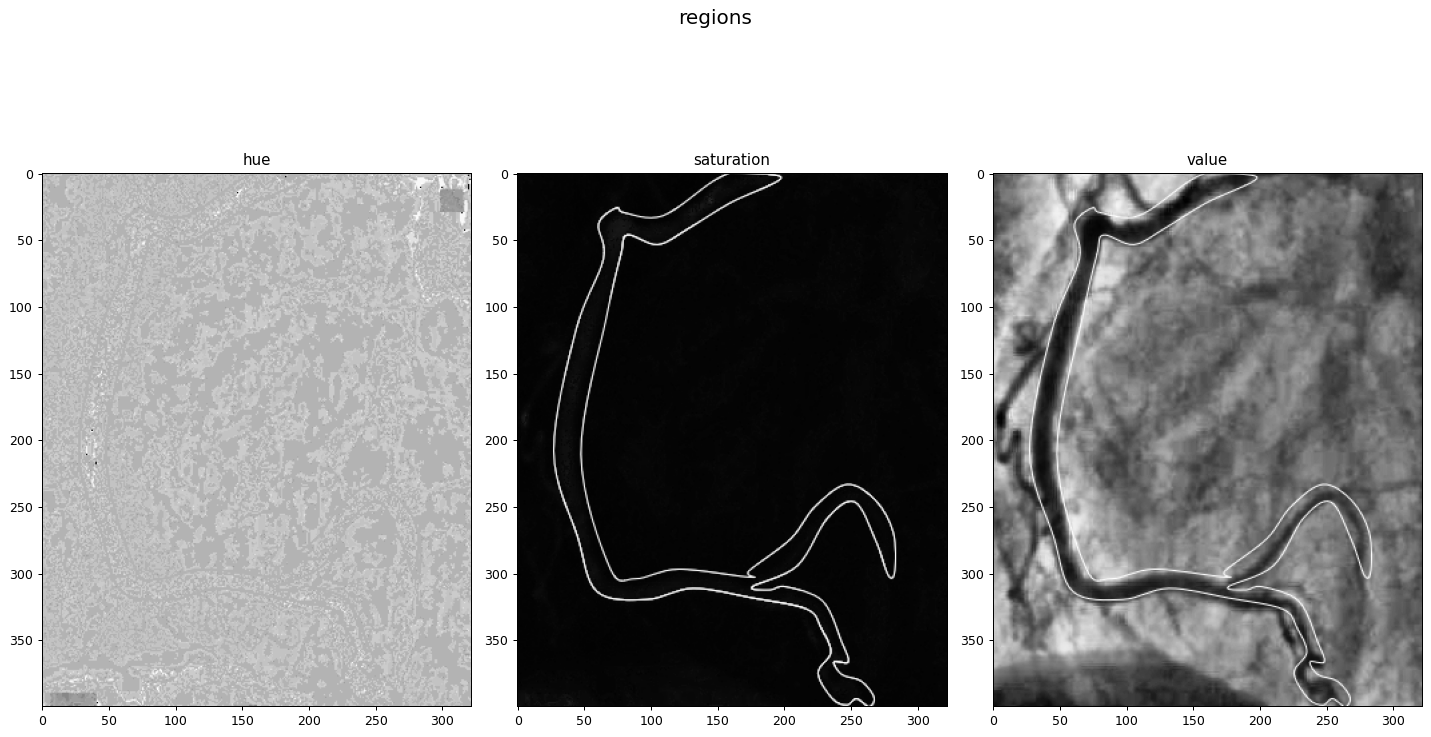

In [13]:
hsv = cv2.cvtColor(regions_img, cv2.COLOR_BGR2HSV)
show_channels(hsv, 'regions', subtitles=['hue', 'saturation', 'value'])

# Find the region boundary contour

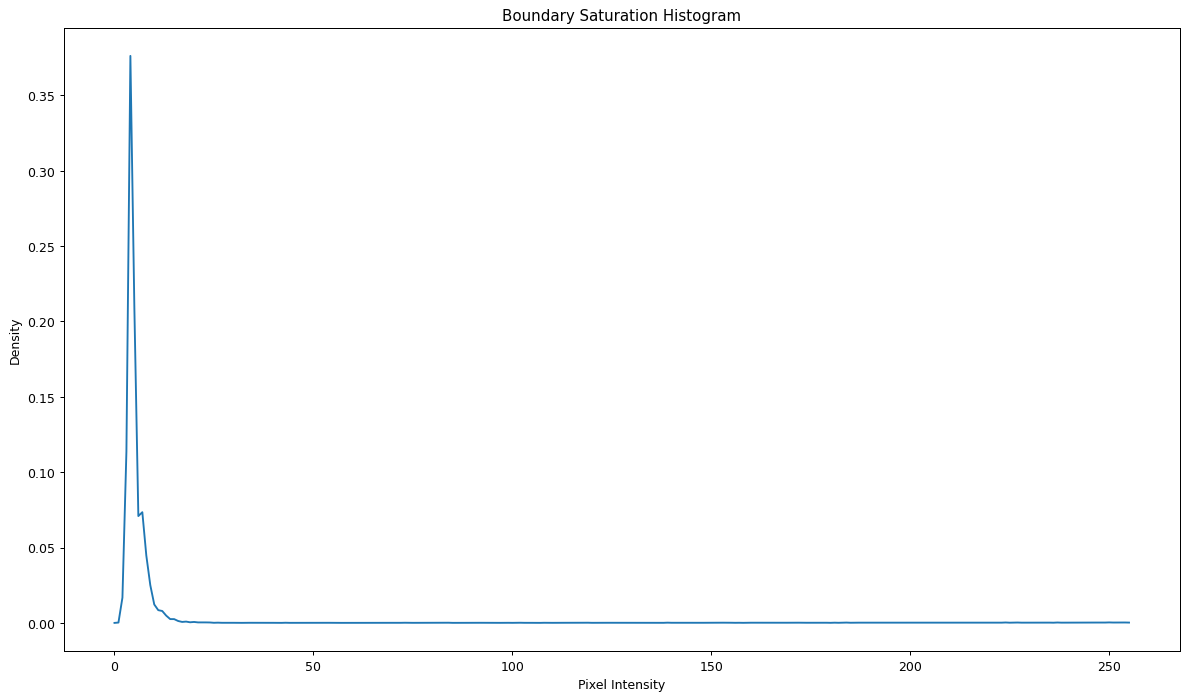

In [14]:
bins, hist = histogram_plot(hsv[:,:,1], "Boundary Saturation Histogram")

## Compute threshold level

In [15]:
percentile = 0.98 # empirically derived
bin_index = np.argmax( np.cumsum(hist) >= percentile*np.sum(hist) )
print(f"Bin={bins[bin_index]} meets or exceens percentile={percentile}")

Bin=119.0 meets or exceens percentile=0.98


## Perform Threshold

Text(0.5, 1.0, 'Thresholded Saturation')

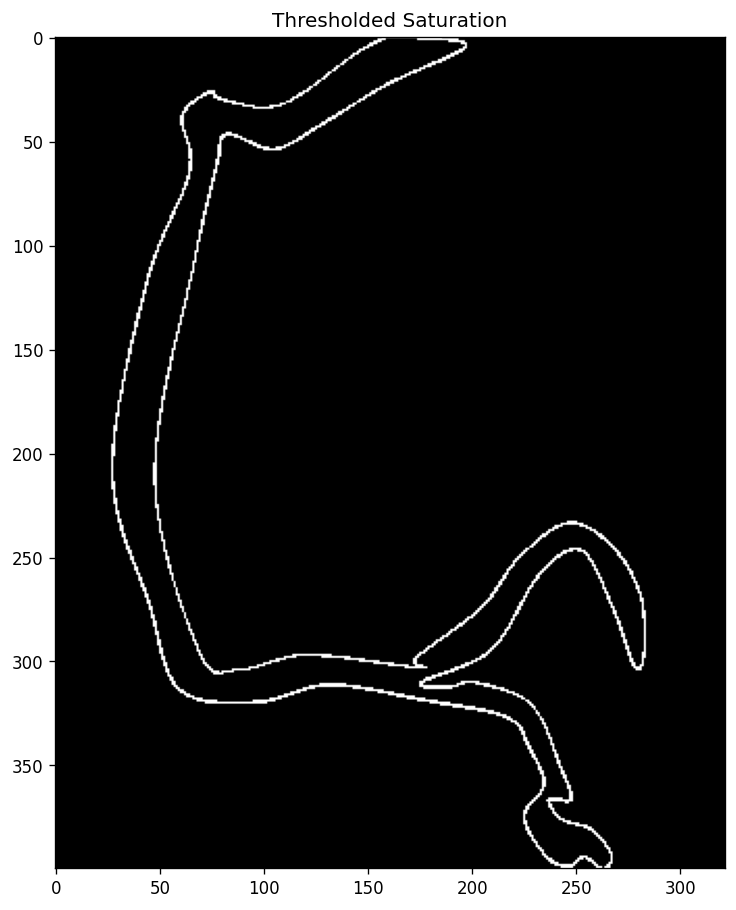

In [16]:
_, saturation_thresholded = cv2.threshold(hsv[:,:,1], bins[bin_index], 255, cv2.THRESH_BINARY)
plt.figure(figsize=(16,9), dpi=120)
plt.imshow(saturation_thresholded, 'grey')
plt.title("Thresholded Saturation")

## Mask for training

contour_img.shape=(400, 322, 3)


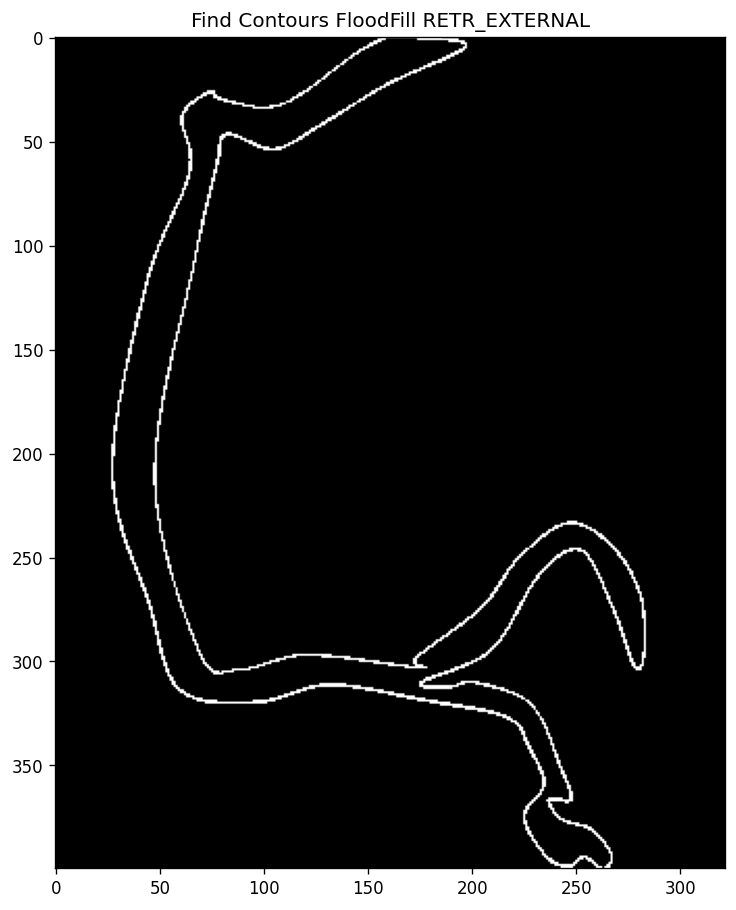

In [17]:
contours, _ = cv2.findContours(
    image=np.array(saturation_thresholded, dtype=np.uint8),
    mode=cv2.RETR_EXTERNAL,
    method=cv2.CHAIN_APPROX_SIMPLE
)
mask = np.zeros(img.shape, np.uint8)
contour_img = cv2.drawContours(
    image=mask, 
    contours=contours, 
    contourIdx=-1, 
    color=(255,255,255), 
    thickness=cv2.FILLED
)
plt.figure(figsize=(16,9), dpi=120)
_ = plt.imshow(contour_img, 'gray')
plt.title("Find Contours FloodFill RETR_EXTERNAL")
print(f"contour_img.shape={contour_img.shape}")

# Graphcut Segmentation

In [27]:
def graphCutSeg(img : NDArray, rio_mask : NDArray):
    # img = cv2.imread('input/input.png')
    # img = cv2.cvtColor(img, cv.COLOR_BGR2RGB)
    
    plt.figure(figsize=(16,9), dpi=120)
    plt.subplot(2,3,1)
    plt.imshow(img)
    
    rows,cols,_ = img.shape
    mask = np.zeros((rows,cols), np.uint8)
    input_mask = cv2.cvtColor( rio_mask.copy(), cv2.COLOR_RGB2GRAY )
    #mask 
    #mask[mask==0] = cv2.GC_BGD
    mask[input_mask>0] = cv2.GC_FGD
    #print(f"rio_mask.shape={rio_mask.shape} rio_mask.dtype={rio_mask.dtype} mask.shape={mask.shape} mask.dtype={mask.dtype}")
    print_info('img', img)
    print_info('mask', mask)
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    x0,y0 = ( int(cols/2),int(rows/2) )
    x1,y1 = ( cols-1, rows-1 )
    rect = (x0, y0, x1-x0, y1-y0)
    iter = 1
    cv2.grabCut(
        img,
        mask,
        rect,
        bgdModel,
        fgdModel,
        iter,
        cv2.GC_INIT_WITH_MASK
    )
    
    plt.imshow(mask, 'gray')
    
    plt.show()

In [28]:
mask.ravel().any(cv2.GC_BGD)

True

img.shape=(400, 322, 3) img.dtype=uint8
mask.shape=(400, 322) mask.dtype=uint8


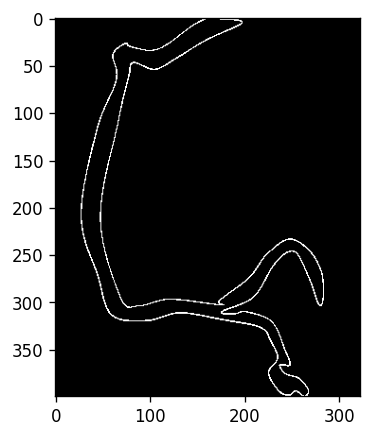

In [29]:

graphCutSeg(regions_img, mask)

How to reuse models from grabcut in OpenCV  
https://stackoverflow.com/questions/66476128/how-to-reuse-models-from-grabcut-in-opencv